# Students
- Gabriele Bellavia \[matric.num]
- Luigi Belli \[matric.num]
- Margherita Lera \[matric.num]
- Giovanni Andrea Maida - 2159404

# Gradient descent & Deep Neural Networks

In [14]:
import numpy as np

import os
import json
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense, Dropout
import keras_tuner
from kerastuner.engine.trial import Trial
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

rng = np.random.default_rng(1758)

plt.rcParams['font.size'] = 13



%run useful.py

In [8]:
class RandomSearch(keras_tuner.RandomSearch):
    histories = {}

    def on_epoch_end(self, trial, model, epoch, logs=None):
        trial_id = trial.trial_id
        trial_history = self.histories.setdefault(trial_id, {})
        for metric, value in logs.items():
            trial_history.setdefault(metric, []).append(value)

    def on_trial_end(self, trial):
        super().on_trial_end(trial)

        self.plot_and_save_history(trial)

    def plot_and_save_history(self, trial: Trial):
        trial_id = trial.trial_id
        trial_history = self.histories[trial_id]

        # Create directory for trial if it doesn't exist
        trial_dir = self.get_trial_dir(trial_id)
        os.makedirs(trial_dir, exist_ok=True)

        plt.figure(figsize=(12, 8))  # Create a larger figure

        for metric_name, metric_values in trial_history.items():
            plt.plot(metric_values, label=metric_name)  # Add label for legend

        plt.title("Metrics History")
        plt.xlabel("Step")
        plt.ylabel("Value")
        plt.legend()  # Add legend
        plt.savefig(os.path.join(trial_dir, "metrics.png"))
        plt.close()

        # Save history to JSON file
        history_file = os.path.join(trial_dir, "history.json")
        with open(history_file, "w") as f:
            json.dump(trial_history, f, indent=4)

    def plot_best_trials(self, num_models, wrap_columns=4, smooth_factor=0.5, suffix=""):
        best_trials = self.oracle.get_best_trials(num_models)
        num_trials = len(best_trials)

        rows = (num_trials - 1) // wrap_columns + 1
        cols = min(num_trials, wrap_columns)

        fig, axes = plt.subplots(rows, cols, figsize=(20, 5))
        # fig.subplots_adjust(hspace=0.4)
        # fig.tight_layout()

        for i, trial in enumerate(best_trials):
            trial_id = trial.trial_id
            trial_dir = self.get_trial_dir(trial_id)
            history_file = os.path.join(trial_dir, "history.json")

            with open(history_file, "r") as f:
                trial_history = json.load(f)

            ax = axes[i // cols, i % cols] if rows > 1 else axes[i]
            for metric_name, metric_values in trial_history.items():
                smoothed_values = self.smooth_values(metric_values, smooth_factor)
                ax.plot(smoothed_values, label=f"Trial {trial_id}: {metric_name}")

            ax.set_title(f"Trial {trial_id}")
            ax.set_xlabel("Step")
            ax.set_ylabel("Value")
            ax.legend()

        plt.savefig(os.path.join(self.oracle._project_dir, f"best_trials_metrics_{suffix}.png"))
        plt.close()

    def smooth_values(self, values, smooth_factor):
        """
        Smooth values with moving average
        In this example implementation, the smooth_values method takes in a list of values and a smooth_factor between 0 and 1.
        It first checks if the smooth_factor is within the valid range (0 to 1). If it's not, it returns the original values without any smoothing.
        Next, it calculates the number of smoothed values based on the smooth_factor.
        It then iterates over the values list, applying the simple moving average (SMA) technique to calculate the smoothed value at each index.
        The number of values used for the moving average calculation increases gradually until it reaches the desired number of smoothed values.
        After that, a fixed window size is used for calculating the moving average.
        # Code generated by chatgpt
        """
        if smooth_factor <= 0.0 or smooth_factor >= 1.0:
            return values

        num_values = len(values)
        num_smoothed_values = int(num_values * (1 - smooth_factor)) + 1
        smoothed_values = []

        for i in range(num_smoothed_values):
            start_index = max(0, i - num_smoothed_values + 1)
            end_index = i + 1
            subset = values[start_index:end_index]
            smoothed_value = sum(subset) / len(subset)
            smoothed_values.append(smoothed_value)

        for i in range(num_smoothed_values, num_values):
            start_index = i - num_smoothed_values + 1
            end_index = i + 1
            subset = values[start_index:end_index]
            smoothed_value = sum(subset) / num_smoothed_values
            smoothed_values.append(smoothed_value)

        return smoothed_values

## Read data

In [9]:
# Keras works with numpy arrays: just use them from the start

TYPE=3
# data point size
L=8
# span of each component
B=10
perc_train = 0.8
x = np.loadtxt(filename("data",L,TYPE), delimiter=' ')
y = np.loadtxt(filename("labels",L,TYPE), delimiter=' ')
y = y.astype("int")
N = len(x)
# average and std.dev.
x_mean = np.mean(x,axis=0)
x_std  = np.std(x,axis=0)

N_train = int(perc_train * N)

## Standardize data

In [10]:
print("before rescaling:\nmean value=", x_mean,"\nstd. dev.=",x_std)
def Standardize(x,m,s):
    """
    rescale each component using its mean and standard deviation
    """
    N = len(x)
    # assuming len(m)=len(s)=len(x[0])
    mm,ss = np.tile(m,(N,1)), np.tile(s,(N,1))
    return (x-mm)/ss
x = Standardize(x,x_mean,x_std)
print("after rescaling:\nmean value=", x.mean(axis=0),"\nstd. dev.=",x.std(axis=0))

before rescaling:
mean value= [5.01860571 5.01726228 5.02153857 5.08947968 5.10248206 5.03670082
 4.88645281 5.05411547] 
std. dev.= [2.86912607 2.89535235 2.87312372 2.86324409 2.90278676 2.91948328
 2.92549254 2.89281292]
after rescaling:
mean value= [ 2.53633226e-15  9.27924404e-16 -1.44884105e-15 -2.38371996e-15
 -2.85274582e-15 -2.02196593e-15 -1.09010023e-15 -1.53632662e-15] 
std. dev.= [1. 1. 1. 1. 1. 1. 1. 1.]


## Split training and test data

In [11]:
(x_train, y_train) = (x[0:N_train],y[0:N_train])
(x_test, y_test) = (x[N_train:],y[N_train:])
print("Train:",len(x_train),"\t Test:",len(x_test))

Train: 1600 	 Test: 400


## 1) Random Search of best hyperparameters

## Define the model with Keras / Tensorflow

In [15]:
def build_model(hp):
    model = Sequential()
    
    # Input layer
    model.add(Dense(L, input_shape=(L,), activation='relu'))
    hidd_active = hp.Choice('hidd_activation', ['sigmoid','relu','elu'])
    
    # 3 not so hidden layers
    for layer_num in range(1, 4):
        model.add(Dense(20, activation=hidd_active))
        model.add(Dropout(hp.Float(f'Dropout_{layer_num}', min_value=0, max_value=0.2, step=0.1)))

    # Output layer
    model.add(Dense(1,activation='sigmoid'))
    learning_rate = hp.Choice('lr', [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1])
    hyper_optimizer = hp.Choice('optimizer', ['adam', 'sgd_nesterov', 'RMSprop', 'adamax', 'adagrad'])

    # Define sgd_nesterov
    if hyper_optimizer == 'sgd_nesterov': hyper_optimizer = SGD(learning_rate=learning_rate, nesterov=True)
        
    model.compile(loss='binary_crossentropy', optimizer=hyper_optimizer, metrics=["accuracy"])
    return model

build_model(keras_tuner.HyperParameters())
tuner = RandomSearch(hypermodel=build_model, objective="val_accuracy", max_trials=5, executions_per_trial=1, overwrite=True, project_name='search')
tuner.search(x_train[200:], y_train[200:], epochs=100, validation_data=(x_train[:200], y_train[:200]))

Trial 5 Complete [00h 00m 40s]
val_accuracy: 0.6299999952316284

Best val_accuracy So Far: 0.7250000238418579
Total elapsed time: 00h 03m 27s


In [16]:
models = tuner.get_best_models(num_models=4)
tuner.results_summary(num_trials=15)


/home/teobaldo/anaconda3/envs/LCP/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adamax', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/home/teobaldo/anaconda3/envs/LCP/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/home/teobaldo/anaconda3/envs/LCP/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adagrad', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Results summary
Results in ./search
Showing 15 best trials
Objective(name="val_accuracy", direction="max")

Trial 0 summary
Hyperparameters:
hidd_activation: elu
Dropout_1: 0.1
Dropout_2: 0.0
Dropout_3: 0.2
lr: 0.0001
optimizer: adamax
Score: 0.7250000238418579

Trial 4 summary
Hyperparameters:
hidd_activation: sigmoid
Dropout_1: 0.0
Dropout_2: 0.0
Dropout_3: 0.0
lr: 1e-06
optimizer: RMSprop
Score: 0.6299999952316284

Trial 2 summary
Hyperparameters:
hidd_activation: sigmoid
Dropout_1: 0.1
Dropout_2: 0.0
Dropout_3: 0.1
lr: 1e-06
optimizer: adagrad
Score: 0.5649999976158142

Trial 3 summary
Hyperparameters:
hidd_activation: relu
Dropout_1: 0.2
Dropout_2: 0.0
Dropout_3: 0.1
lr: 0.01
optimizer: sgd_nesterov
Score: 0.550000011920929

Trial 1 summary
Hyperparameters:
hidd_activation: relu
Dropout_1: 0.0
Dropout_2: 0.1
Dropout_3: 0.2
lr: 1e-06
optimizer: sgd_nesterov
Score: 0.49000000953674316


## Cross Validation

In [17]:
def k_fold_cross_validation(x_train, y_train, k, models):
    # Initialize holders
    best = -1
    best_perf = -1
    results = []
    best_num = -1
    # Divide training set in K folds
    idx = rng.permutation(np.arange(x_train.shape[0]))
    x_folds, y_folds = np.array_split(x_train[idx, :], k), np.array_split(y_train[idx], k)
    
    for i in range(len(models)):
        model_perf = 0
        for test in range(k):
            x_train_fold = np.concatenate([x for i, x in enumerate(x_folds) if i != test])
            y_train_fold = np.concatenate([x for i, x in enumerate(y_folds) if i != test])
            x_validate_fold, y_validate_fold = x_folds[test], y_folds[test]
            k_model = models[i].fit(x_train_fold, y_train_fold, verbose=0)
            model_perf += models[i].evaluate(x_validate_fold, y_validate_fold, verbose=0)[1]
        model_perf /= k
        results.append(model_perf)
        if (best_perf < model_perf):
            best, best_num = models[i], i
            best_perf = model_perf
    return best, best_num, results


best_model, which_best, results = k_fold_cross_validation(x_train, y_train, 5, models)
print(which_best)
print(results)

0
[0.721875011920929, 0.6606249928474426, 0.4668749988079071, 0.5256250023841857]


## Training

In [18]:
fit = best_model.fit(x_train, y_train, batch_size = 50, validation_data=(x_test,y_test), verbose=0)

## Grid to show preditions

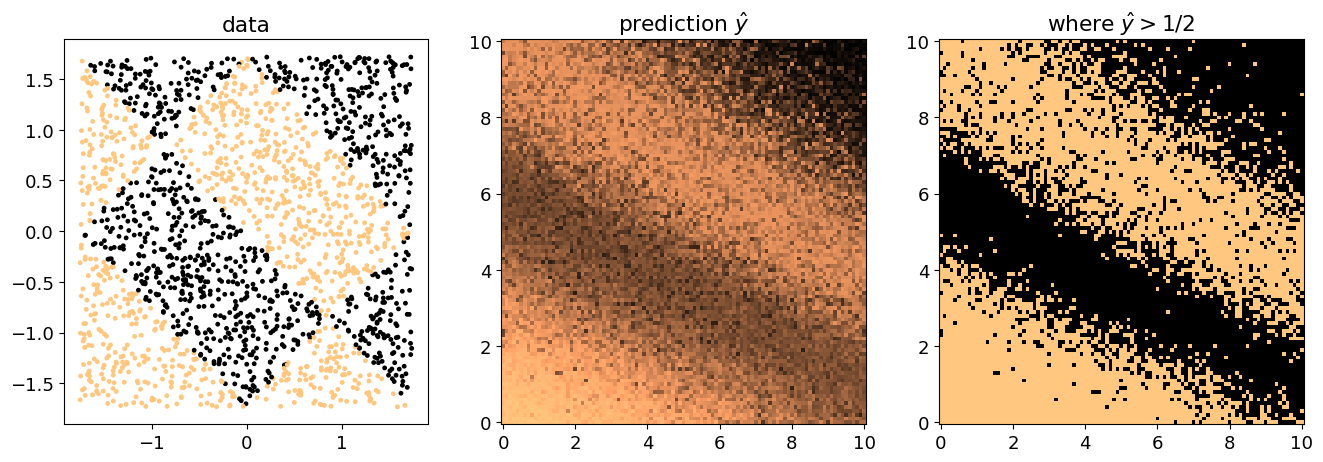

In [19]:
dX = .1
X1 = np.arange(0,10+dX, dX)
LG = len(X1)
X, Y = np.meshgrid(X1, X1)
allXY = np.reshape((np.array((X,Y)).T),(LG**2,2))
grid = np.random.rand(LG**2,L)*B
grid[:,:2] = allXY
grid_r=Standardize(grid,x_mean,x_std)

pred = best_model.predict(grid_r, verbose=0)

fig,AX=plt.subplots(1,3,figsize=(16,5.))
ax=AX[0]
ax.scatter(x[:,0],x[:,1],c=y,s=6)
ax.set_title("data")
ax=AX[1]
ax.pcolormesh(X1,X1,pred.reshape((LG, LG)))
ax.set_title("prediction $\\hat y$")
ax=AX[2]
pred01=np.copy(pred)
pred01[pred>0.5]=1
pred01[pred<=0.5]=0
ax.pcolormesh(X1,X1,pred01.reshape((LG, LG)))
ax.set_title("where $\\hat y > 1/2$")
plt.show()